In [1]:
import torch
import numpy as np
import IPython.display as ipd
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
import pandas as pd

from data.text import text_to_sequence, phoneme_duration_to_sequence
from train import load_model
from dataset import TextMelDurLoader

In [13]:
config_path = "mellotron-singer/configs/train.yaml"
synthesizer_checkpoint_path = "/home/podcastle/Documents/mellotron-singer/models/base_model/checkpoint_45000"
vocoder_checkpoint_path = "/home/podcastle/workspace/vc-training-pipeline/models/vocoders/hifi_gan/universal_pretrained/g_02500000"

hparams_ = OmegaConf.load(config_path)
device = torch.device('cpu')

In [3]:
synthesizer = load_model(hparams_)
synthesizer.eval()
synthesizer.to(device)
print("Loading checkpoint '{}'".format(synthesizer_checkpoint_path))
synthesizer_checkpoint_dict = torch.load(synthesizer_checkpoint_path)
synthesizer.load_state_dict(synthesizer_checkpoint_dict['state_dict'])

769 1024 2
Loading checkpoint '/home/podcastle/Documents/mellotron-singer/models/base_model/checkpoint_45000'


<All keys matched successfully>

In [4]:
hparams = OmegaConf.load('/home/podcastle/workspace/vc-training-pipeline/configs/config.yaml')
vocoder = Generator(hparams).to(device)

vocoder_checkpoint_dict = load_checkpoint(vocoder_checkpoint_path, device)
vocoder.load_state_dict(vocoder_checkpoint_dict['generator'])
vocoder.eval()
vocoder.remove_weight_norm()

NameError: name 'Generator' is not defined

In [4]:
def get_f0(filename):
    f0 = np.load(filename)[0]

    # Padding zeros in place of sos and sos tokens
    f0 = np.insert(f0, 0, [0, 0])
    f0 = np.append(f0, [0, 0])[None, :]

    f0 = torch.from_numpy(f0)
    return f0

def load_durations_from_numpy(path, in_seconds=False):
    durations = np.load(path)
    if in_seconds:
        durations = np.insert(durations, 0, [0.02])
        durations = np.append(durations, [0.02])
    else:
        durations = np.insert(durations, 0, [2])
        durations = np.append(durations, [2])
    return torch.from_numpy(durations)

def get_embedding(embed_path):
    return torch.from_numpy(np.load(embed_path, allow_pickle=True))

In [18]:
durations_in_frames = load_durations_from_numpy("/home/podcastle/Documents/GM_preprocessed/duration/GM_0.npy").unsqueeze(0).long()
f0s = get_f0("/home/podcastle/Documents/GM_preprocessed/f0s/GM_0.npy").unsqueeze(1).float()
embedding = get_embedding("/home/podcastle/Documents/LibriTTS_processed/averaged_embeddings/1018.npy").unsqueeze(0).float()

with open("/home/podcastle/Documents/GM_preprocessed/train.txt", 'r') as f:
    phonemes = f.readline().split("|")[1]

phoneme_ids = phoneme_duration_to_sequence(phonemes)
phoneme_ids = torch.IntTensor(phoneme_ids).unsqueeze(0)

In [19]:
durations_in_frames.size()

torch.Size([1, 25])

unpacked_durations size: torch.Size([1, 261])
durations_in_frames size: torch.Size([1, 25])
f0s size torch.Size([1, 1, 261])
f0_dummy size torch.Size([1, 1, 1])


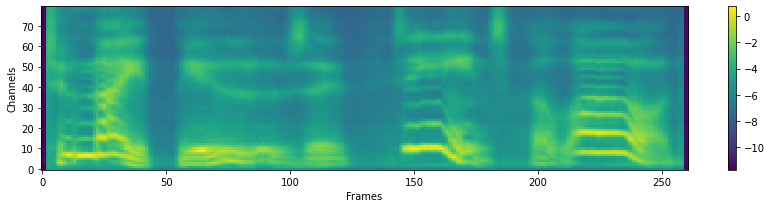

In [20]:
with torch.no_grad():
    _, mel, _, alignment = synthesizer.semi_inference(phoneme_ids, durations_in_frames, f0s, embedding)
    
alignment = alignment.squeeze(-1)

mel_np = mel.float().data.cpu().numpy()[0]
alignment_np = alignment.float().data.cpu().numpy()[0].T

%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 3))
im = ax.imshow(mel_np, aspect="auto", origin="lower",
               interpolation='none')

plt.colorbar(im, ax=ax)
plt.xlabel("Frames")
plt.ylabel("Channels")
plt.tight_layout()

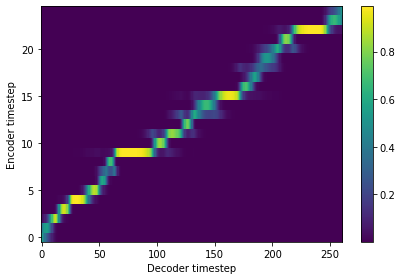

In [21]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(6, 4))
im = ax.imshow(alignment_np, aspect='auto', origin='lower',
               interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()

In [22]:
import sys

sys.path.append('/home/podcastle/workspace/vc-training-pipeline/')

from vocoder.models import Generator
from vocoder.utils import load_checkpoint

In [23]:
hparams = OmegaConf.load('/home/podcastle/workspace/vc-training-pipeline/configs/config.yaml')
vocoder = Generator(hparams).to(device)

vocoder_checkpoint_dict = load_checkpoint(vocoder_checkpoint_path, device)
vocoder.load_state_dict(vocoder_checkpoint_dict['generator'])
vocoder.eval()
vocoder.remove_weight_norm()

Loading '/home/podcastle/workspace/vc-training-pipeline/models/vocoders/hifi_gan/universal_pretrained/g_02500000'
Complete.


In [24]:
with torch.no_grad():
    audio = vocoder(mel)
    audio = audio.squeeze()

ipd.Audio(audio, rate=22050) 